# Conditional Wassertein GAN with Gradient Penalty for Faces

---
## Imports

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torchvision
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from utils.utils import summarize
from utils.logger import Logger, Plotter
from utils.vis import plot_img, plot_nearest_neighbor, set_cmap

ModuleNotFoundError: No module named 'utils'

---
## Setting

In [2]:
# data file
csv_file = './data/age_gender.csv'

# flag for displaying the architecture
show_model = False

# seed for random numbers
torch.manual_seed(13)

# device
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
print('device', device)

# set colormap
set_cmap('gray')

# logger: 
#    (1) Wasserstein distance
#    (2) generator loss
#    (3) discriminator loss
# NOTE: 
#    (a): metrics (2) and (3) are minmimized during training
#    (b): metrics (2) and (3 )are logged as scores to be maximized
format_str  = '{:03d} | wasserstein {: .4f} | gen score {: .4f} | dis score: {: .4f}'

device cuda:3


In [3]:
# wrapper function to disply images
def display_images(X, ncols=5):
    reverse_transform = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t : 255. * torch.clamp(t, 0, 1)),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t.detach().cpu().numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ])
    plot_img(X, ncols=ncols, transform=reverse_transform, figscale=1.5)

---
## Parameters

In [4]:
img_size      = 48             # size of resized images
num_classes   = 2              # number of classes
nc            = 1              # number of channels in the images
batch_size    = 64             # batch size
n_epochs      = 300            # number of epochs
nz            = 100            # size of latent vector z
nf_gen        = 32             # number of filters for generator
nf_dis        = 32             # number of filters for discriminator
slope_gen     = 0.1            # slope of generator's leaky ReLU
slope_dis     = 0.1            # slope of discriminator's leaky ReLU
lr_gen        = 0.0003         # learning rate for generator
lr_dis        = 0.0001         # learning rate for discriminator
betas         = (0.5, 0.999)   # betas for Adam optmizers
dropout       = 0.3            # dropout rate for discriminator
lambda_gp     = 10.0           # parameter of gradient penalty

---
## Face Data

In [1]:
transform = transforms.Compose([
    transforms.Lambda(lambda t : Image.fromarray(t.astype(np.uint8))),
    transforms.RandomHorizontalFlip(), 
    #transforms.RandomCrop(img_size, padding=4),
    transforms.ToTensor(),
    transforms.Lambda(lambda t : 2*t - 1)
    
])

class FaceDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        df = pd.read_csv(csv_file)
        df = df[(df['age'] >= 20) & (df['age'] <= 60)]
        self.X = self._get_imgs(df)
        self.y = df['gender'].values
        self.transform = transform

    def _get_imgs(self, df):
        imgs = df.iloc[:, 4]
        X = [np.array(item.split(), dtype=np.uint8) for item in imgs]
        X = np.array(X).reshape(-1, img_size, img_size)
        return X
   
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        if self.transform:
            X = self.transform(X)
        return X, y

face_data = FaceDataset(csv_file, transform)
data_loader = DataLoader(face_data, batch_size=batch_size, shuffle=True)


# check dataset
for x, y in data_loader:  
    print('Image batch dimensions:', x.shape)
    print('Max pixel value:', f'{x.max().numpy():.2f}')
    print('Min pixel value:', f'{x.min().numpy():.2f}')
    print(y)
    break

X, y = next(iter(data_loader))
display_images(X[:20])

NameError: name 'transforms' is not defined

---
## Generator

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(nz+num_classes, 8*nf_gen, 3, 1, 0, bias=False),
            #nn.BatchNorm2d(8*nf_gen),
            nn.LeakyReLU(slope_gen, True),
            
            nn.ConvTranspose2d(8*nf_gen, 4*nf_gen, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(4*nf_gen),
            nn.LeakyReLU(slope_gen, True),
            
            nn.ConvTranspose2d(4*nf_gen, 2*nf_gen, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(2*nf_gen),
            nn.LeakyReLU(slope_gen, True),

            nn.ConvTranspose2d(2*nf_gen, nf_gen, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(nf_gen),
            nn.LeakyReLU(slope_gen, True),
            
            nn.ConvTranspose2d(nf_gen, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, y):
        z = self._concat(z, y)
        return self.net(z)
        
    def generate(self, z, y):
        '''Return fakes in eval-modus. Don't use in train mode.'''
        self.eval()
        with torch.no_grad():
            fakes = self(z, y)
        return fakes

    def _concat(self, z, y):
        y_onehot = F.one_hot(y, num_classes).reshape(z.size(0), -1, 1, 1)
        return torch.cat((z, y_onehot), dim=1)


# show architecture
if show_model: summarize(Generator(), [1, nz+num_classes, 1, 1])

---
## Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc+num_classes, nf_dis, 4, 2, 1, bias=False),
            nn.LeakyReLU(slope_dis, True),
            #nn.Dropout(dropout),
            
            nn.Conv2d(nf_dis, 2*nf_dis,  4, 2, 1, bias=False),
            nn.BatchNorm2d(2*nf_dis),
            nn.LeakyReLU(slope_dis, True),
            nn.Dropout(dropout),

            nn.Conv2d(2*nf_gen, 4*nf_gen, 4, 2, 1, bias=False),
            nn.BatchNorm2d(4*nf_gen),
            nn.LeakyReLU(slope_gen, True),
            nn.Dropout(dropout),
            
            nn.Conv2d(4*nf_dis, 8*nf_dis, 4, 2, 1, bias=False),
            nn.BatchNorm2d(8*nf_dis),
            nn.LeakyReLU(slope_dis, True),
            nn.Dropout(dropout),

            nn.Conv2d(8*nf_dis, 1, 3, 1, 0, bias=False)
    )

    def forward(self, x, y):
        x = self._concat(x, y)
        return self.net(x).view(-1)

    def _concat(self, X, y):
        y_onehot = F.one_hot(y, num_classes).reshape(X.size(0), -1, 1, 1)
        ones = torch.ones(X.size(0), num_classes, X.size(2), X.size(3), dtype=X.dtype, device=device)
        y_onehot = ones * y_onehot
        return torch.cat((X, y_onehot), dim=1)

# show architecture
if show_model: summarize(Discriminator(), [1, nc+num_classes, 48, 48])

---
## Gradient Penalty

See notebook `autograd.pynb` for an explanation of the `autograd.grad` function. 

In [8]:
from torch import autograd 

def gradient_penalty(X_real, X_fake, y_orig, net_dis):
    
    # get batch size
    bs = X_real.size(0)

    # interpolations
    alpha = torch.rand(bs, 1, 1, 1, device=device)
    X = alpha * X_real.detach() + (1 - alpha) * X_fake.detach()
    X.requires_grad_(True)
    
    # discriminator output of interpolations
    y_hat = net_dis(X, y_orig).sum()
    
    # compute gradients 
    gradients = autograd.grad(outputs=y_hat, inputs=X, create_graph=True)[0]

    gradients = gradients.view(bs, -1)
    return ((gradients.norm(2, dim=1) - 1)**2).sum()


---
## Train Model

001 | wasserstein  3.0956 | gen score -3.7764 | dis score:  2.7800
002 | wasserstein  0.3556 | gen score -3.2484 | dis score:  0.2675
003 | wasserstein  0.3773 | gen score -3.7331 | dis score:  0.2830
004 | wasserstein  0.1433 | gen score -3.3416 | dis score: -0.6618
005 | wasserstein -0.0590 | gen score -0.4238 | dis score: -0.5686
      average gradient magnitude: 0.031222


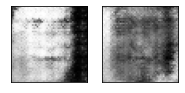

006 | wasserstein -0.0916 | gen score -0.9834 | dis score: -0.4596
007 | wasserstein -0.0365 | gen score -0.3909 | dis score: -0.4038
008 | wasserstein -0.0412 | gen score -0.3037 | dis score: -0.3800
009 | wasserstein  0.0240 | gen score -0.8956 | dis score: -0.2691
010 | wasserstein  0.0506 | gen score -1.2814 | dis score: -0.2202
      average gradient magnitude: 0.0195746


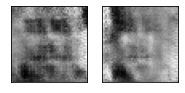

011 | wasserstein  0.0983 | gen score -1.3878 | dis score: -0.1047
012 | wasserstein  0.1170 | gen score -1.9192 | dis score: -0.0538
013 | wasserstein  0.0707 | gen score -2.1708 | dis score: -0.0839
014 | wasserstein  0.0018 | gen score -2.0822 | dis score: -0.1323
015 | wasserstein -0.0433 | gen score -2.1105 | dis score: -0.1674
      average gradient magnitude: 0.016337


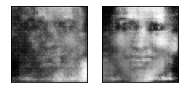

016 | wasserstein -0.0435 | gen score -1.7972 | dis score: -0.1476
017 | wasserstein -0.0361 | gen score -1.9276 | dis score: -0.1452
018 | wasserstein -0.0213 | gen score -1.9678 | dis score: -0.1303
019 | wasserstein -0.0278 | gen score -1.5704 | dis score: -0.1262
020 | wasserstein -0.0069 | gen score -1.3487 | dis score: -0.0884
      average gradient magnitude: 0.020725


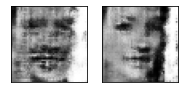

021 | wasserstein -0.0136 | gen score -1.4874 | dis score: -0.0980
022 | wasserstein -0.0166 | gen score -1.6580 | dis score: -0.0965
023 | wasserstein -0.0221 | gen score -1.5846 | dis score: -0.1024
024 | wasserstein -0.0387 | gen score -2.1647 | dis score: -0.1122
025 | wasserstein -0.0042 | gen score -2.0371 | dis score: -0.0812
      average gradient magnitude: 0.0193039


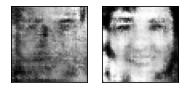

026 | wasserstein -0.0247 | gen score -1.7768 | dis score: -0.0939
027 | wasserstein -0.0136 | gen score -1.8395 | dis score: -0.0805
028 | wasserstein -0.0126 | gen score -1.8363 | dis score: -0.0844
029 | wasserstein -0.0034 | gen score -2.0539 | dis score: -0.0784
030 | wasserstein  0.0239 | gen score -2.2288 | dis score: -0.0428
      average gradient magnitude: 0.0123221


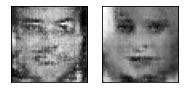

031 | wasserstein  0.0205 | gen score -2.3074 | dis score: -0.0480
032 | wasserstein -0.0180 | gen score -1.8899 | dis score: -0.0876
033 | wasserstein  0.0299 | gen score -1.9353 | dis score: -0.0425
034 | wasserstein -0.0212 | gen score -1.8400 | dis score: -0.0878
035 | wasserstein -0.0046 | gen score -1.8763 | dis score: -0.0703
      average gradient magnitude: 0.020962


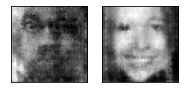

036 | wasserstein -0.0295 | gen score -1.9196 | dis score: -0.0942
037 | wasserstein  0.0124 | gen score -2.1512 | dis score: -0.0506
038 | wasserstein -0.0125 | gen score -2.2039 | dis score: -0.0736
039 | wasserstein -0.0094 | gen score -2.2775 | dis score: -0.0682
040 | wasserstein  0.0142 | gen score -2.1059 | dis score: -0.0443
      average gradient magnitude: 0.0150248


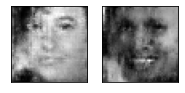

041 | wasserstein -0.0321 | gen score -2.1663 | dis score: -0.0844
042 | wasserstein  0.0155 | gen score -2.1848 | dis score: -0.0442
043 | wasserstein  0.0034 | gen score -2.1093 | dis score: -0.0511
044 | wasserstein  0.0086 | gen score -2.0647 | dis score: -0.0427
045 | wasserstein  0.0181 | gen score -2.0766 | dis score: -0.0333
      average gradient magnitude: 0.015782


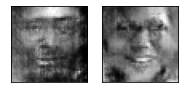

046 | wasserstein  0.0109 | gen score -2.0173 | dis score: -0.0393
047 | wasserstein  0.0228 | gen score -2.1126 | dis score: -0.0232
048 | wasserstein  0.0070 | gen score -1.9454 | dis score: -0.0381
049 | wasserstein  0.0292 | gen score -1.9411 | dis score: -0.0160
050 | wasserstein  0.0039 | gen score -2.1306 | dis score: -0.0423
      average gradient magnitude: 0.0143256


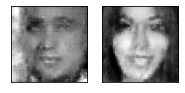

051 | wasserstein  0.0147 | gen score -2.1186 | dis score: -0.0308
052 | wasserstein  0.0108 | gen score -2.2083 | dis score: -0.0323
053 | wasserstein  0.0146 | gen score -2.2630 | dis score: -0.0286
054 | wasserstein  0.0436 | gen score -2.2627 | dis score:  0.0014
055 | wasserstein -0.0025 | gen score -2.1724 | dis score: -0.0439
      average gradient magnitude: 0.0143067


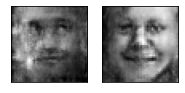

056 | wasserstein  0.0328 | gen score -2.0019 | dis score: -0.0130
057 | wasserstein  0.0129 | gen score -2.0324 | dis score: -0.0302
058 | wasserstein  0.0281 | gen score -2.1760 | dis score: -0.0109
059 | wasserstein  0.0172 | gen score -2.0313 | dis score: -0.0267
060 | wasserstein  0.0472 | gen score -2.0215 | dis score:  0.0063
      average gradient magnitude: 0.0170729


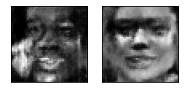

061 | wasserstein  0.0393 | gen score -2.1949 | dis score: -0.0012
062 | wasserstein  0.0230 | gen score -2.1094 | dis score: -0.0153
063 | wasserstein  0.0303 | gen score -2.0674 | dis score: -0.0083
064 | wasserstein  0.0254 | gen score -2.1758 | dis score: -0.0147
065 | wasserstein  0.0604 | gen score -2.0502 | dis score:  0.0214
      average gradient magnitude: 0.0156648


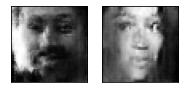

066 | wasserstein  0.0452 | gen score -2.1562 | dis score:  0.0076
067 | wasserstein  0.0309 | gen score -1.9616 | dis score: -0.0076
068 | wasserstein  0.0345 | gen score -1.8722 | dis score: -0.0054
069 | wasserstein  0.0510 | gen score -1.9633 | dis score:  0.0117
070 | wasserstein  0.0445 | gen score -1.9538 | dis score:  0.0068
      average gradient magnitude: 0.0180997


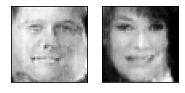

071 | wasserstein  0.0515 | gen score -1.8898 | dis score:  0.0140
072 | wasserstein  0.0487 | gen score -1.8327 | dis score:  0.0098
073 | wasserstein  0.0559 | gen score -1.8502 | dis score:  0.0199
074 | wasserstein  0.0694 | gen score -1.9168 | dis score:  0.0329
075 | wasserstein  0.0615 | gen score -1.9522 | dis score:  0.0247
      average gradient magnitude: 0.0194193


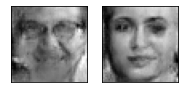

076 | wasserstein  0.0584 | gen score -2.1784 | dis score:  0.0233
077 | wasserstein  0.0615 | gen score -2.1468 | dis score:  0.0279
078 | wasserstein  0.0529 | gen score -2.1300 | dis score:  0.0190
079 | wasserstein  0.0431 | gen score -2.2542 | dis score:  0.0079
080 | wasserstein  0.0446 | gen score -2.1985 | dis score:  0.0091
      average gradient magnitude: 0.0159771


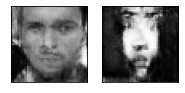

081 | wasserstein  0.0582 | gen score -2.3530 | dis score:  0.0217
082 | wasserstein  0.0537 | gen score -2.0957 | dis score:  0.0205
083 | wasserstein  0.0547 | gen score -1.9446 | dis score:  0.0227
084 | wasserstein  0.0520 | gen score -2.0220 | dis score:  0.0167
085 | wasserstein  0.0565 | gen score -1.9502 | dis score:  0.0223
      average gradient magnitude: 0.0191076


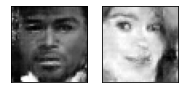

086 | wasserstein  0.0614 | gen score -2.0285 | dis score:  0.0259
087 | wasserstein  0.0663 | gen score -2.0393 | dis score:  0.0336
088 | wasserstein  0.0691 | gen score -2.0123 | dis score:  0.0359
089 | wasserstein  0.0673 | gen score -2.0439 | dis score:  0.0341
090 | wasserstein  0.0669 | gen score -2.1479 | dis score:  0.0344
      average gradient magnitude: 0.0162795


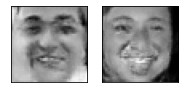

091 | wasserstein  0.0707 | gen score -2.1183 | dis score:  0.0381
092 | wasserstein  0.0843 | gen score -2.0535 | dis score:  0.0518
093 | wasserstein  0.0661 | gen score -2.1773 | dis score:  0.0344
094 | wasserstein  0.0563 | gen score -2.0154 | dis score:  0.0249
095 | wasserstein  0.0664 | gen score -2.0270 | dis score:  0.0334
      average gradient magnitude: 0.0181416


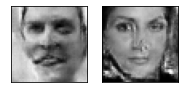

096 | wasserstein  0.0721 | gen score -2.1026 | dis score:  0.0393
097 | wasserstein  0.0656 | gen score -2.0583 | dis score:  0.0323
098 | wasserstein  0.0682 | gen score -1.8837 | dis score:  0.0371
099 | wasserstein  0.0582 | gen score -2.0097 | dis score:  0.0274
100 | wasserstein  0.0849 | gen score -2.0976 | dis score:  0.0535
      average gradient magnitude: 0.0196575


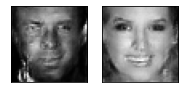

101 | wasserstein  0.0668 | gen score -2.0812 | dis score:  0.0355
102 | wasserstein  0.0655 | gen score -2.0107 | dis score:  0.0348
103 | wasserstein  0.0448 | gen score -2.0045 | dis score:  0.0122
104 | wasserstein  0.0680 | gen score -2.0435 | dis score:  0.0367
105 | wasserstein  0.0734 | gen score -1.9705 | dis score:  0.0430
      average gradient magnitude: 0.0197255


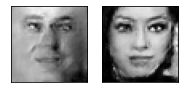

106 | wasserstein  0.0579 | gen score -1.9258 | dis score:  0.0268
107 | wasserstein  0.0816 | gen score -1.9220 | dis score:  0.0504
108 | wasserstein  0.0786 | gen score -1.7414 | dis score:  0.0466
109 | wasserstein  0.0791 | gen score -1.6939 | dis score:  0.0490
110 | wasserstein  0.0670 | gen score -1.8081 | dis score:  0.0357
      average gradient magnitude: 0.0175113


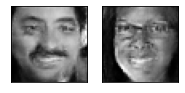

111 | wasserstein  0.0698 | gen score -1.8824 | dis score:  0.0371
112 | wasserstein  0.0719 | gen score -1.7589 | dis score:  0.0409
113 | wasserstein  0.1074 | gen score -1.7897 | dis score:  0.0768
114 | wasserstein  0.0727 | gen score -1.9049 | dis score:  0.0414
115 | wasserstein  0.0568 | gen score -1.9317 | dis score:  0.0270
      average gradient magnitude: 0.0199606


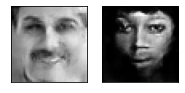

116 | wasserstein  0.0815 | gen score -1.9517 | dis score:  0.0513
117 | wasserstein  0.0745 | gen score -1.8193 | dis score:  0.0437
118 | wasserstein  0.0685 | gen score -1.9523 | dis score:  0.0377
119 | wasserstein  0.0566 | gen score -1.8655 | dis score:  0.0262
120 | wasserstein  0.0709 | gen score -1.8546 | dis score:  0.0406
      average gradient magnitude: 0.0174935


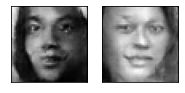

121 | wasserstein  0.0798 | gen score -2.0348 | dis score:  0.0499
122 | wasserstein  0.0812 | gen score -1.9899 | dis score:  0.0504
123 | wasserstein  0.0784 | gen score -1.9208 | dis score:  0.0489
124 | wasserstein  0.0720 | gen score -2.0042 | dis score:  0.0420
125 | wasserstein  0.0633 | gen score -1.9033 | dis score:  0.0334
      average gradient magnitude: 0.0184396


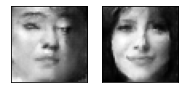

126 | wasserstein  0.0866 | gen score -2.0470 | dis score:  0.0553
127 | wasserstein  0.0746 | gen score -1.9914 | dis score:  0.0443
128 | wasserstein  0.0796 | gen score -2.0032 | dis score:  0.0488
129 | wasserstein  0.0886 | gen score -1.9942 | dis score:  0.0584
130 | wasserstein  0.0716 | gen score -2.1249 | dis score:  0.0419
      average gradient magnitude: 0.0199064


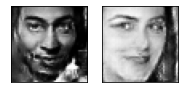

131 | wasserstein  0.0731 | gen score -2.0011 | dis score:  0.0440
132 | wasserstein  0.0665 | gen score -1.9294 | dis score:  0.0353
133 | wasserstein  0.0773 | gen score -1.8014 | dis score:  0.0485
134 | wasserstein  0.0625 | gen score -1.8851 | dis score:  0.0329
135 | wasserstein  0.0761 | gen score -1.8198 | dis score:  0.0470
      average gradient magnitude: 0.0178489


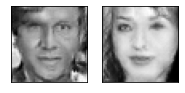

136 | wasserstein  0.0649 | gen score -1.9049 | dis score:  0.0349
137 | wasserstein  0.0859 | gen score -1.8774 | dis score:  0.0558
138 | wasserstein  0.0800 | gen score -1.9280 | dis score:  0.0491
139 | wasserstein  0.0796 | gen score -1.9089 | dis score:  0.0516
140 | wasserstein  0.0954 | gen score -1.9333 | dis score:  0.0679
      average gradient magnitude: 0.0214718


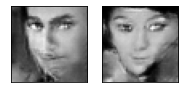

141 | wasserstein  0.0762 | gen score -1.9483 | dis score:  0.0471
142 | wasserstein  0.0760 | gen score -2.0379 | dis score:  0.0470
143 | wasserstein  0.0888 | gen score -1.9558 | dis score:  0.0601
144 | wasserstein  0.0899 | gen score -2.0435 | dis score:  0.0609
145 | wasserstein  0.0858 | gen score -1.9837 | dis score:  0.0564
      average gradient magnitude: 0.0189117


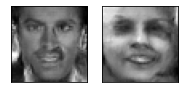

146 | wasserstein  0.0904 | gen score -1.9955 | dis score:  0.0612
147 | wasserstein  0.0821 | gen score -1.9173 | dis score:  0.0535
148 | wasserstein  0.0836 | gen score -1.9345 | dis score:  0.0551
149 | wasserstein  0.0801 | gen score -1.9718 | dis score:  0.0515
150 | wasserstein  0.1036 | gen score -1.9147 | dis score:  0.0751
      average gradient magnitude: 0.0188372


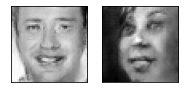

151 | wasserstein  0.0858 | gen score -2.0270 | dis score:  0.0572
152 | wasserstein  0.0801 | gen score -2.0345 | dis score:  0.0507
153 | wasserstein  0.0818 | gen score -2.0200 | dis score:  0.0532
154 | wasserstein  0.0748 | gen score -1.9239 | dis score:  0.0457
155 | wasserstein  0.0909 | gen score -1.8998 | dis score:  0.0627
      average gradient magnitude: 0.0189302


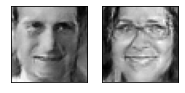

156 | wasserstein  0.0795 | gen score -2.0220 | dis score:  0.0508
157 | wasserstein  0.0738 | gen score -2.0790 | dis score:  0.0447
158 | wasserstein  0.0730 | gen score -1.8702 | dis score:  0.0426
159 | wasserstein  0.0792 | gen score -2.0571 | dis score:  0.0502
160 | wasserstein  0.0892 | gen score -2.0240 | dis score:  0.0595
      average gradient magnitude: 0.016888


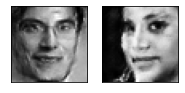

161 | wasserstein  0.0958 | gen score -1.9141 | dis score:  0.0666
162 | wasserstein  0.0856 | gen score -1.7560 | dis score:  0.0561
163 | wasserstein  0.1132 | gen score -1.7561 | dis score:  0.0837
164 | wasserstein  0.0907 | gen score -1.7152 | dis score:  0.0624
165 | wasserstein  0.0944 | gen score -1.7969 | dis score:  0.0659
      average gradient magnitude: 0.0192338


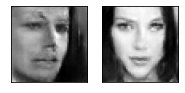

166 | wasserstein  0.0929 | gen score -1.8023 | dis score:  0.0633
167 | wasserstein  0.0973 | gen score -1.8632 | dis score:  0.0684
168 | wasserstein  0.0965 | gen score -1.9175 | dis score:  0.0675
169 | wasserstein  0.0899 | gen score -2.0412 | dis score:  0.0598
170 | wasserstein  0.0900 | gen score -2.1103 | dis score:  0.0599
      average gradient magnitude: 0.0192731


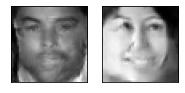

171 | wasserstein  0.0995 | gen score -2.0813 | dis score:  0.0697
172 | wasserstein  0.0932 | gen score -2.1067 | dis score:  0.0637
173 | wasserstein  0.1022 | gen score -1.9419 | dis score:  0.0734
174 | wasserstein  0.1014 | gen score -1.9452 | dis score:  0.0724
175 | wasserstein  0.0755 | gen score -1.8347 | dis score:  0.0466
      average gradient magnitude: 0.0252942


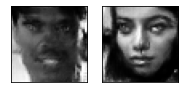

176 | wasserstein  0.0935 | gen score -1.9030 | dis score:  0.0639
177 | wasserstein  0.0931 | gen score -1.8620 | dis score:  0.0636
178 | wasserstein  0.0911 | gen score -1.8952 | dis score:  0.0611
179 | wasserstein  0.0994 | gen score -1.8581 | dis score:  0.0704
180 | wasserstein  0.0896 | gen score -1.8525 | dis score:  0.0604
      average gradient magnitude: 0.0205418


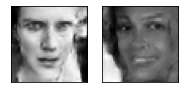

181 | wasserstein  0.1006 | gen score -1.9355 | dis score:  0.0715
182 | wasserstein  0.1091 | gen score -2.0932 | dis score:  0.0808
183 | wasserstein  0.1086 | gen score -2.2329 | dis score:  0.0797
184 | wasserstein  0.0731 | gen score -2.2051 | dis score:  0.0443
185 | wasserstein  0.0931 | gen score -2.0434 | dis score:  0.0637
      average gradient magnitude: 0.0208748


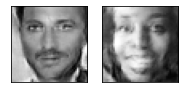

186 | wasserstein  0.0987 | gen score -2.0970 | dis score:  0.0694
187 | wasserstein  0.0964 | gen score -2.1708 | dis score:  0.0659
188 | wasserstein  0.1086 | gen score -2.0806 | dis score:  0.0793
189 | wasserstein  0.0921 | gen score -2.1814 | dis score:  0.0624
190 | wasserstein  0.0938 | gen score -2.0163 | dis score:  0.0635
      average gradient magnitude: 0.018902


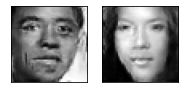

191 | wasserstein  0.0969 | gen score -1.9741 | dis score:  0.0667
192 | wasserstein  0.0854 | gen score -2.0869 | dis score:  0.0556
193 | wasserstein  0.0844 | gen score -2.2110 | dis score:  0.0555
194 | wasserstein  0.0988 | gen score -2.2371 | dis score:  0.0702
195 | wasserstein  0.0912 | gen score -2.0402 | dis score:  0.0621
      average gradient magnitude: 0.0195869


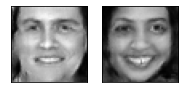

196 | wasserstein  0.0938 | gen score -1.9991 | dis score:  0.0640
197 | wasserstein  0.0953 | gen score -1.8057 | dis score:  0.0660
198 | wasserstein  0.1058 | gen score -1.7985 | dis score:  0.0772
199 | wasserstein  0.1153 | gen score -1.7171 | dis score:  0.0864
200 | wasserstein  0.1112 | gen score -1.9300 | dis score:  0.0820
      average gradient magnitude: 0.0218967


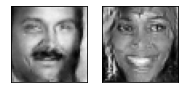

201 | wasserstein  0.0928 | gen score -1.8746 | dis score:  0.0647
202 | wasserstein  0.0966 | gen score -1.8892 | dis score:  0.0676
203 | wasserstein  0.1113 | gen score -1.8967 | dis score:  0.0815
204 | wasserstein  0.0939 | gen score -1.9346 | dis score:  0.0643
205 | wasserstein  0.0985 | gen score -1.8973 | dis score:  0.0690
      average gradient magnitude: 0.0187188


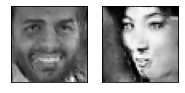

206 | wasserstein  0.1097 | gen score -1.9886 | dis score:  0.0811
207 | wasserstein  0.1045 | gen score -1.9877 | dis score:  0.0763
208 | wasserstein  0.1198 | gen score -1.9209 | dis score:  0.0896
209 | wasserstein  0.0856 | gen score -1.9149 | dis score:  0.0567
210 | wasserstein  0.0891 | gen score -1.8554 | dis score:  0.0601
      average gradient magnitude: 0.0218697


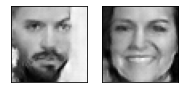

211 | wasserstein  0.0932 | gen score -1.9087 | dis score:  0.0645
212 | wasserstein  0.1095 | gen score -1.8915 | dis score:  0.0806
213 | wasserstein  0.1103 | gen score -2.0464 | dis score:  0.0826
214 | wasserstein  0.0990 | gen score -1.9681 | dis score:  0.0703
215 | wasserstein  0.0795 | gen score -1.9710 | dis score:  0.0506
      average gradient magnitude: 0.0215209


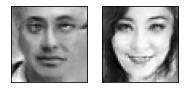

216 | wasserstein  0.0878 | gen score -1.8681 | dis score:  0.0586
217 | wasserstein  0.0955 | gen score -1.8045 | dis score:  0.0673
218 | wasserstein  0.1035 | gen score -1.7463 | dis score:  0.0762
219 | wasserstein  0.1186 | gen score -1.8498 | dis score:  0.0889
220 | wasserstein  0.1132 | gen score -1.7588 | dis score:  0.0854
      average gradient magnitude: 0.0219997


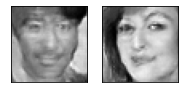

221 | wasserstein  0.1146 | gen score -1.7539 | dis score:  0.0866
222 | wasserstein  0.0969 | gen score -1.7651 | dis score:  0.0682
223 | wasserstein  0.1158 | gen score -1.8387 | dis score:  0.0872
224 | wasserstein  0.1150 | gen score -1.9341 | dis score:  0.0858
225 | wasserstein  0.1136 | gen score -2.0008 | dis score:  0.0855
      average gradient magnitude: 0.0190741


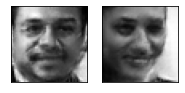

226 | wasserstein  0.1043 | gen score -1.9127 | dis score:  0.0771
227 | wasserstein  0.0998 | gen score -1.8845 | dis score:  0.0704
228 | wasserstein  0.1121 | gen score -2.0504 | dis score:  0.0823
229 | wasserstein  0.0909 | gen score -1.9651 | dis score:  0.0620
230 | wasserstein  0.0884 | gen score -1.9985 | dis score:  0.0599
      average gradient magnitude: 0.0229741


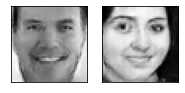

231 | wasserstein  0.0895 | gen score -1.8568 | dis score:  0.0607
232 | wasserstein  0.1021 | gen score -1.8213 | dis score:  0.0736
233 | wasserstein  0.1169 | gen score -1.7617 | dis score:  0.0880
234 | wasserstein  0.1234 | gen score -1.8392 | dis score:  0.0948
235 | wasserstein  0.0895 | gen score -1.9737 | dis score:  0.0605
      average gradient magnitude: 0.0189574


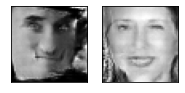

236 | wasserstein  0.0977 | gen score -1.9584 | dis score:  0.0683
237 | wasserstein  0.1122 | gen score -2.0567 | dis score:  0.0836
238 | wasserstein  0.1136 | gen score -2.2167 | dis score:  0.0842
239 | wasserstein  0.0965 | gen score -2.0833 | dis score:  0.0674
240 | wasserstein  0.1122 | gen score -2.1504 | dis score:  0.0829
      average gradient magnitude: 0.0195759


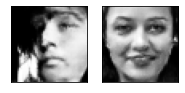

241 | wasserstein  0.1134 | gen score -2.0370 | dis score:  0.0846
242 | wasserstein  0.1095 | gen score -2.1077 | dis score:  0.0808
243 | wasserstein  0.1019 | gen score -2.0836 | dis score:  0.0728
244 | wasserstein  0.1168 | gen score -2.0521 | dis score:  0.0883
245 | wasserstein  0.1014 | gen score -1.9019 | dis score:  0.0728
      average gradient magnitude: 0.0194292


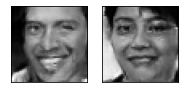

246 | wasserstein  0.0940 | gen score -1.9496 | dis score:  0.0639
247 | wasserstein  0.1162 | gen score -1.9168 | dis score:  0.0877
248 | wasserstein  0.0890 | gen score -1.8888 | dis score:  0.0607
249 | wasserstein  0.1171 | gen score -1.9836 | dis score:  0.0891
250 | wasserstein  0.1027 | gen score -2.0495 | dis score:  0.0734
      average gradient magnitude: 0.0211425


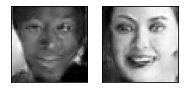

251 | wasserstein  0.1179 | gen score -1.9589 | dis score:  0.0893
252 | wasserstein  0.1116 | gen score -1.9701 | dis score:  0.0823
253 | wasserstein  0.1070 | gen score -1.7991 | dis score:  0.0782
254 | wasserstein  0.1038 | gen score -1.9901 | dis score:  0.0745
255 | wasserstein  0.1112 | gen score -2.1900 | dis score:  0.0819
      average gradient magnitude: 0.0228583


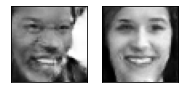

256 | wasserstein  0.0939 | gen score -2.0435 | dis score:  0.0638
257 | wasserstein  0.1152 | gen score -2.1585 | dis score:  0.0852
258 | wasserstein  0.1091 | gen score -2.2165 | dis score:  0.0781
259 | wasserstein  0.1142 | gen score -2.1806 | dis score:  0.0845
260 | wasserstein  0.1245 | gen score -2.1110 | dis score:  0.0955
      average gradient magnitude: 0.0198466


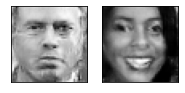

261 | wasserstein  0.1021 | gen score -2.1444 | dis score:  0.0731
262 | wasserstein  0.1234 | gen score -2.2488 | dis score:  0.0942
263 | wasserstein  0.1050 | gen score -2.2558 | dis score:  0.0762
264 | wasserstein  0.1214 | gen score -2.2581 | dis score:  0.0920
265 | wasserstein  0.1168 | gen score -2.1095 | dis score:  0.0876
      average gradient magnitude: 0.0218522


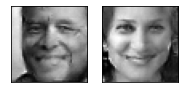

266 | wasserstein  0.0927 | gen score -2.0431 | dis score:  0.0641
267 | wasserstein  0.0932 | gen score -1.9541 | dis score:  0.0642
268 | wasserstein  0.1173 | gen score -1.9661 | dis score:  0.0883
269 | wasserstein  0.1056 | gen score -2.0204 | dis score:  0.0774
270 | wasserstein  0.1065 | gen score -2.0469 | dis score:  0.0776
      average gradient magnitude: 0.0211143


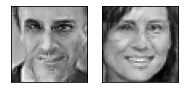

271 | wasserstein  0.0892 | gen score -2.1096 | dis score:  0.0600
272 | wasserstein  0.0989 | gen score -2.0601 | dis score:  0.0688
273 | wasserstein  0.1095 | gen score -2.0495 | dis score:  0.0819
274 | wasserstein  0.1343 | gen score -2.0809 | dis score:  0.1055
275 | wasserstein  0.1144 | gen score -2.1789 | dis score:  0.0863
      average gradient magnitude: 0.0228064


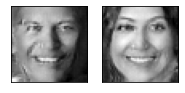

276 | wasserstein  0.1005 | gen score -2.1880 | dis score:  0.0713
277 | wasserstein  0.1164 | gen score -2.1816 | dis score:  0.0874
278 | wasserstein  0.0980 | gen score -2.1046 | dis score:  0.0684
279 | wasserstein  0.1231 | gen score -2.1804 | dis score:  0.0939
280 | wasserstein  0.1039 | gen score -2.1665 | dis score:  0.0745
      average gradient magnitude: 0.0204321


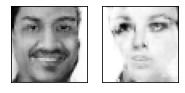

281 | wasserstein  0.1203 | gen score -2.1756 | dis score:  0.0914
282 | wasserstein  0.1263 | gen score -2.2575 | dis score:  0.0967
283 | wasserstein  0.1188 | gen score -2.1011 | dis score:  0.0909
284 | wasserstein  0.0986 | gen score -1.9930 | dis score:  0.0696
285 | wasserstein  0.1010 | gen score -2.0134 | dis score:  0.0717
      average gradient magnitude: 0.0216567


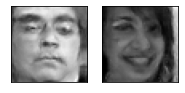

286 | wasserstein  0.1062 | gen score -1.9358 | dis score:  0.0777
287 | wasserstein  0.1101 | gen score -2.0684 | dis score:  0.0810
288 | wasserstein  0.1086 | gen score -1.9396 | dis score:  0.0791
289 | wasserstein  0.1235 | gen score -1.9729 | dis score:  0.0946
290 | wasserstein  0.1064 | gen score -2.0855 | dis score:  0.0762
      average gradient magnitude: 0.0212841


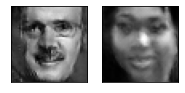

291 | wasserstein  0.1012 | gen score -1.9418 | dis score:  0.0718
292 | wasserstein  0.1252 | gen score -1.9555 | dis score:  0.0957
293 | wasserstein  0.1083 | gen score -2.0023 | dis score:  0.0797
294 | wasserstein  0.1237 | gen score -1.9897 | dis score:  0.0939
295 | wasserstein  0.1096 | gen score -1.9443 | dis score:  0.0814
      average gradient magnitude: 0.020341


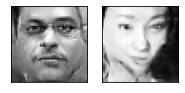

296 | wasserstein  0.1080 | gen score -2.0066 | dis score:  0.0790
297 | wasserstein  0.1071 | gen score -2.0757 | dis score:  0.0780
298 | wasserstein  0.1264 | gen score -2.1412 | dis score:  0.0979
299 | wasserstein  0.1126 | gen score -1.9818 | dis score:  0.0836
300 | wasserstein  0.1231 | gen score -2.0559 | dis score:  0.0946
      average gradient magnitude: 0.0180207


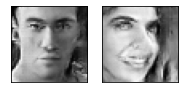

In [9]:
# return latent noise 
def get_z(batch_size, nz):
    return torch.randn(batch_size, nz, 1, 1, device=device)

# generate new fakes
def generate(num_per_class):
    z = get_z(num_per_class*num_classes, nz)
    y = torch.arange(num_classes, device=device)
    y = y.repeat(num_per_class)
    y = y.reshape(-1,1,1,1)
    return net_gen.generate(z, y)

### Compile model ############################################################# 

# generator and discriminator network
net_gen = Generator().to(device)
net_dis = Discriminator().to(device)

# optimizer for generator and discriminator
optim_gen = torch.optim.Adam(net_gen.parameters(), lr=lr_gen, betas = betas)
optim_dis = torch.optim.Adam(net_dis.parameters(), lr=lr_dis, betas = betas)

# logger for 3 metrics
logger = Logger(3, format_str)

### Train #####################################################################
net_dis = net_dis.train()
net_gen = net_gen.train()
size = len(face_data)

for epoch in range(1, n_epochs+1):

    for X, y in data_loader:

        b_size = X.size(0)
        y_orig = y.to(device)
        X_real = X.to(device) 
        X_fake = net_gen(get_z(b_size, nz), y_orig)

        #*** train discriminator ******************************************
        
        #--- loss for real images
        loss_real = net_dis(X_real, y_orig).sum()
        
        #--- loss for fake images
        loss_fake = net_dis(X_fake.detach(), y_orig).sum()
        
        #--- total loss
        d_ws = loss_real - loss_fake                              # Wasserstein distance
        gp = gradient_penalty(X_real, X_fake, y_orig, net_dis)    # gradient penalty
        loss = -d_ws + lambda_gp * gp                             # total loss

        #--- update
        optim_dis.zero_grad()
        loss.backward()
        optim_dis.step()
        
        #--- result
        d_ws, loss_d = d_ws.item(), loss.item()

        
        #*** train generator ***********************************************
        
        #--- train with fake images
        loss = -net_dis(X_fake, y_orig).sum()
        
        #--- update
        optim_gen.zero_grad()
        loss.backward()
        optim_gen.step()

        #--- result
        loss_g = loss.item()


        #*** log batch ********************************************************
        logger.log_batch([d_ws, -loss_g, -loss_d])

        
    #*** log & report *********************************************************
    logger.log_epoch(size)
    logger.log_grads(net_gen)
    if not epoch % 1:
        logger.info()
    if not epoch % 5: 
        logger.info_grad()
        display_images(generate(1), ncols=2)

---
## Results

In [10]:
plotter = Plotter(logger)

### Loss

The plot shows the discriminator and generator losses as a function of the number of epochs. Note that the losses are normalized to the interval $[0, 1]$

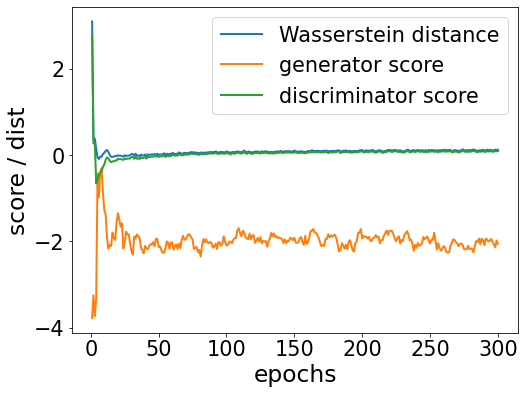

In [11]:
 plotter.plot_scores(normalize=False)

### Gradients

The plot shows the absolute magnitude of the generator's gradient. 

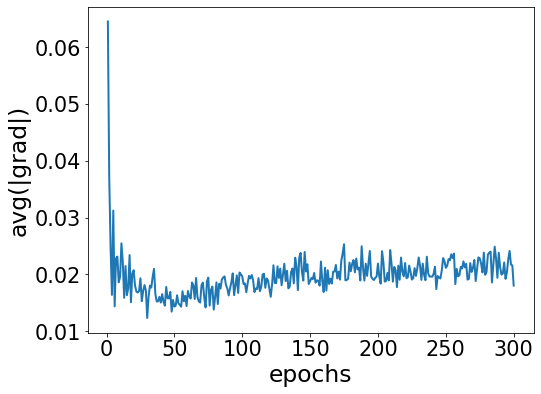

In [12]:
plotter.plot_grads()

---
### Fakes

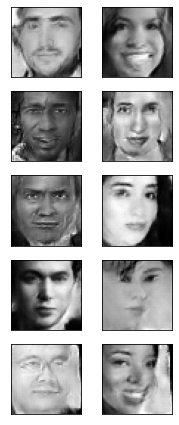

In [13]:
display_images(generate(5), ncols=2)